In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d 
import matplotlib.pyplot as plt
import pprint
inter = interp1d

In [2]:
def get_fac(wavelength, filter_df):
    """
    Gets the factor filter scales a particular wavelength by,
    or interpolate for the factor if wavelength factor is not explicitly
    provided by filter.
    """
    #print "wavelength {}".format(wavelength)
    fac = filter_df[filter_df[0] == wavelength]
    if len(fac) is 0:
        f = inter(filter_df[0], filter_df[1])
        return f(wavelength)
    else:
        return fac[1]

In [3]:
def truncate_spectra_by_sloan_ranges(spectra):
    """
    Returns dictionary indexed by sloan filters, 
    with values being ndarray of wavelengths from the spectra
    that falls under the sloan filter range.
    """
    
    sloan_ranges = {
        'u': [2980, 4130],
        'g': [3630, 5830],
        'z': [7730, 11230],
        'r': [5380, 7230],
        'i': [6430, 8630]
    }
    
    def get_range(fil):
        fil_range = spectra[(spectra[0] >= sloan_ranges[fil][0]) & (spectra[0] <= sloan_ranges[fil][1])]
        return fil_range
        
    #get_range = lambda fil: spectra[(spectra[0] > sloan_ranges[fil][0]) & (spectra[0] < sloan_ranges[fil][1])]
    
    return {
        'u': get_range('u'),
        'g': get_range('g'),
        'z': get_range('z'),
        'r': get_range('r'),
        'i': get_range('i')
    }

In [20]:
def scale_within_range(sloan_filter, spectra):
    """
    Scales spectra values at each wavelength by corresponding filter transmission.
    """
    spectra_ranges = truncate_spectra_by_sloan_ranges(spectra)
    in_range = spectra_ranges[sloan_filter]

    if len(in_range) == 0:
        return None
    
    range_filter = pd.read_csv("SLOAN_SDSS_"+sloan_filter+".dat", header=None, delimiter=" ")
    get_filter_fac = lambda w: get_fac(w, range_filter)
    get_filter_facs = np.vectorize(get_filter_fac)
    
    w_factors = get_filter_facs(in_range[0]) # assuming order is the same
    scaled = in_range[1] * w_factors
    return scaled

**Calculation to convert flux values to magnitude, based on Vega System:**

Zero Point: 1568.54 (Jy)



In [5]:
def flux_to_magnitude(flux):
    """
    Converts Flux to Apparent Magnitude
    """
    return 3.639e-9 - 2.5*np.log10(flux/1568.54)

In [6]:
def get_magnitudes_at_epoch(spec_at_epoch):
    """
    Gets converted magnitudes for each band, for each spectra.
    """
    spec_at_epoch = spec_at_epoch if type(spec_at_epoch) is str else str(spec_at_epoch)
    
    spectra = pd.read_csv(spec_at_epoch+".csv", header=None, skiprows=[0], usecols=[0,1])    

    sums = {'u':0,'g':0,'z':0,'r':0,'i':0}
    for f in sums.keys():
        n = scale_within_range(f, spectra)
        if n is not None:
            sums[f] = n.sum()
    
    
    f2m = {k:flux_to_magnitude(sums[k]) for k in sums.keys() if sums[k] != 0}
    return f2m
    
    """
    non_zero_sums = filter(lambda s: s != 0, sums.values())
    
    f2m = np.vectorize(flux_to_magnitude)
    return np.asarray(f2m(non_zero_sums)) # discards the filter label
    """

In [7]:
spectra_epoch = {
    1: {'epoch': 54361.00, 'magnitudes': None},
    2: {'epoch': 54363.46, 'magnitudes': None},
    3: {'epoch': 54365.38, 'magnitudes': None},
    4: {'epoch': 54376.32, 'magnitudes': None},
    5: {'epoch': 54376.36, 'magnitudes': None},
    6: {'epoch': 54379.44, 'magnitudes': None},
    7: {'epoch': 54381.35, 'magnitudes': None},
    8: {'epoch': 54381.35, 'magnitudes': None},
    9: {'epoch': 54389.28, 'magnitudes': None},
    10: {'epoch': 54408.21, 'magnitudes': None},
    11: {'epoch': 54408.25,  'magnitudes': None}
}

for i in xrange(1, 12):
    spectra_epoch[i]['magnitudes'] = get_magnitudes_at_epoch(i)
    print spectra_epoch[i]['magnitudes']

{'i': 43.357995699863977, 'r': 41.826991808885381, 'u': 42.898852608684557, 'z': 42.543146280129299, 'g': 40.411444787341068}
{'i': 42.202005334662545, 'r': 40.700516275392616, 'u': 43.17779378490787, 'g': 40.358499208231621}
{'i': 40.0955306391824, 'r': 39.113652052313924, 'u': 43.075518322048332, 'z': 42.061572005458459, 'g': 39.230804311429779}
{'r': 43.338324495473373, 'u': 44.772816483583917, 'g': 41.775188589619098}
{'i': 44.058585117955118, 'r': 42.693581599765473, 'z': 46.26484720887116, 'g': 44.051023393025602}
{'i': 42.879198415597259, 'r': 40.918746326429236, 'u': 44.467681102987427, 'g': 40.938179280802203}
{'r': 41.762484500353374, 'u': 45.87949735300532, 'g': 41.412587462937296}
{'i': 42.950187081686948, 'r': 43.181758883752693, 'z': 44.79768148310805}
{'i': 45.129007849491941, 'r': 43.662274559634199, 'u': 47.519481664966818, 'z': 48.847629371730235, 'g': 43.985715418015978}
{'r': 44.859381189962647, 'u': 47.371916749112408, 'g': 44.120943583981287}
{'i': 44.790933239233

**Epoch and corresponding magnitudes computed:**

In [8]:
pprint.pprint(spectra_epoch)

{1: {'epoch': 54361.0,
     'magnitudes': {'g': 40.411444787341068,
                    'i': 43.357995699863977,
                    'r': 41.826991808885381,
                    'u': 42.898852608684557,
                    'z': 42.543146280129299}},
 2: {'epoch': 54363.46,
     'magnitudes': {'g': 40.358499208231621,
                    'i': 42.202005334662545,
                    'r': 40.700516275392616,
                    'u': 43.17779378490787}},
 3: {'epoch': 54365.38,
     'magnitudes': {'g': 39.230804311429779,
                    'i': 40.0955306391824,
                    'r': 39.113652052313924,
                    'u': 43.075518322048332,
                    'z': 42.061572005458459}},
 4: {'epoch': 54376.32,
     'magnitudes': {'g': 41.775188589619098,
                    'r': 43.338324495473373,
                    'u': 44.772816483583917}},
 5: {'epoch': 54376.36,
     'magnitudes': {'g': 44.051023393025602,
                    'i': 44.058585117955118,
                    '

In [9]:
epochs = [spectra_epoch[x]['epoch'] for x in xrange(1,12)]
magnitudes = [spectra_epoch[x]['magnitudes'] for x in xrange(1,12)]

bands = {'i':{
            'epochs': [],
            'magnitudes': []
        },
         'r':{
            'epochs': [],
            'magnitudes': []
        },
         'u':{
            'epochs': [],
            'magnitudes': []
        },
         'z':{
            'epochs': [],
            'magnitudes': []
        },
         'g':{
            'epochs': [],
            'magnitudes': []
        }
    }

for epoch in xrange(11):
    for band in bands.keys():
        if band in magnitudes[epoch].keys():
            bands[band]['epochs'].append(epochs[epoch])
            bands[band]['magnitudes'].append(magnitudes[epoch][band])

pprint.pprint(bands)

{'g': {'epochs': [54361.0,
                  54363.46,
                  54365.38,
                  54376.32,
                  54376.36,
                  54379.44,
                  54381.35,
                  54389.28,
                  54408.21,
                  54408.25],
       'magnitudes': [40.411444787341068,
                      40.358499208231621,
                      39.230804311429779,
                      41.775188589619098,
                      44.051023393025602,
                      40.938179280802203,
                      41.412587462937296,
                      43.985715418015978,
                      44.120943583981287,
                      50.271051278128866]},
 'i': {'epochs': [54361.0,
                  54363.46,
                  54365.38,
                  54376.36,
                  54379.44,
                  54381.35,
                  54389.28,
                  54408.25],
       'magnitudes': [43.357995699863977,
                      42.2020053

In [10]:
scale_fac = 2.3

In [11]:
"""
f1 = plt.figure()
f1.gca().invert_yaxis()
p1 = f1.add_subplot(111)
for epoch in xrange(11):
    print (epochs[epoch], np.mean(magnitudes[epoch]))
    p1.scatter(epochs[epoch], np.mean(magnitudes[epoch]/scale_fac))
"""

'\nf1 = plt.figure()\nf1.gca().invert_yaxis()\np1 = f1.add_subplot(111)\nfor epoch in xrange(11):\n    print (epochs[epoch], np.mean(magnitudes[epoch]))\n    p1.scatter(epochs[epoch], np.mean(magnitudes[epoch]/scale_fac))\n'

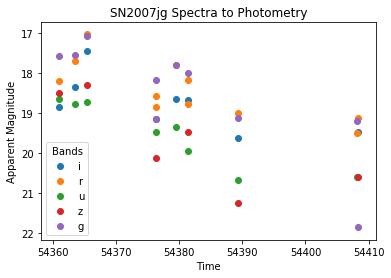

In [18]:
f3 = plt.figure()
f3.gca().invert_yaxis()
p3 = f3.add_subplot(111)
for band in bands.keys():
    p3.scatter(bands[band]['epochs'], np.asarray(bands[band]['magnitudes'])/scale_fac, label=band)
    
p3.legend(title='Bands', loc=0)
p3.set_ylabel('Apparent Magnitude')
p3.set_xlabel('Time')
p3.set_title('SN2007jg Spectra to Photometry')

In [19]:
plt.savefig('spectra_to_photometry_curve.pdf')